### Importation

In [24]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split, Subset
from collections import Counter
import matplotlib.pyplot as plt


### Transformations et préparations des données

In [25]:
data_dir = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums"  # change selon ton environnement

# 🔄 Transformations pour le train/val/test
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 🧾 Dataset complet
dataset = datasets.ImageFolder(data_dir, transform=transform)

# 🔢 Dictionnaire d'encodage des classes
class_names = dataset.classes
label_to_idx = {label: idx for idx, label in enumerate(class_names)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}


### Split Train / Val / Test

In [26]:
# 📊 On divise en 70% train, 15% val, 15% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


### Weighted Sampler sur train_dataset uniquement

In [27]:
# 🟢 On récupère les indices du train
train_indices = train_dataset.indices if isinstance(train_dataset, Subset) else list(range(len(train_dataset)))

# 🟢 On récupère les labels associés aux indices du sous-ensemble train
train_labels = [dataset.samples[i][1] for i in train_indices]

# 🟢 Comptage des labels
label_counts = np.bincount(train_labels)

# 🟢 Calcul des poids inverses
weights = 1. / torch.tensor(label_counts, dtype=torch.float)
sample_weights = [weights[label] for label in train_labels]

# 🟢 Création du WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


### DataLoaders

In [28]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


### Visualisation de la distribution des classes dans chaque split

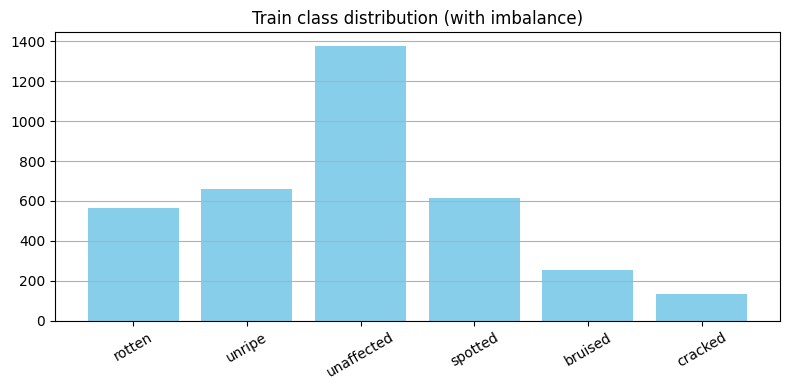

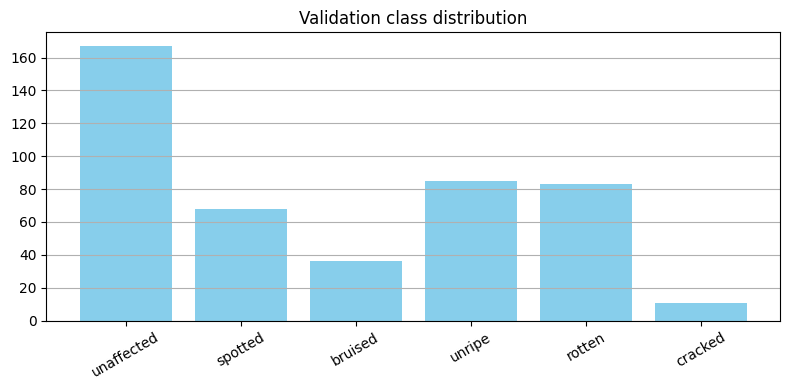

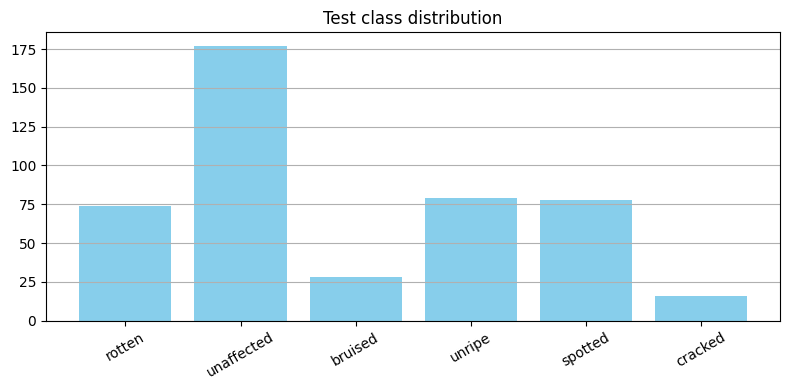

In [29]:
def plot_class_distribution(labels, title):
    counts = Counter(labels)
    classes = [idx_to_label[c] for c in counts.keys()]
    values = list(counts.values())
    plt.figure(figsize=(8, 4))
    plt.bar(classes, values, color='skyblue')
    plt.title(title)
    plt.xticks(rotation=30)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_labels, "Train class distribution (with imbalance)")
val_labels = [dataset.samples[i][1] for i in val_dataset.indices]
plot_class_distribution(val_labels, "Validation class distribution")
test_labels = [dataset.samples[i][1] for i in test_dataset.indices]
plot_class_distribution(test_labels, "Test class distribution")


### Entrainement du modele

### Initialisation des variables d'entraînement

In [30]:
num_epochs = 20
best_val_acc = 0.0
patience = 5
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_model_path = "best_model.pt"


In [31]:
from torchvision.models import resnet50
import torch.nn as nn

# ✅ Détection du périphérique (GPU si dispo)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📦 Charger un modèle pré-entraîné ResNet18
model = resnet50(pretrained=True)

# 🔄 Adapter la couche de sortie à nos 6 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# 🚀 Envoyer le modèle sur le bon périphérique
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
from collections import Counter

# ✅ Accéder au dataset de base et aux indices de la partition d'entraînement
base_dataset = train_dataset.dataset
train_indices = train_dataset.indices

# 🏷️ Récupérer les labels des échantillons dans la portion entraînement
train_labels_list = [base_dataset.samples[i][1] for i in train_indices]
class_counts = Counter(train_labels_list)

# 🧭 Dictionnaires index <-> label
label_to_idx = base_dataset.class_to_idx
idx_to_label = {v: k for k, v in label_to_idx.items()}
class_names = list(label_to_idx.keys())

# 📊 Affichage
print("Répartition des classes dans le train :")
for label, idx in label_to_idx.items():
    print(f"{label:<12}: {class_counts[idx]} images")


Répartition des classes dans le train :
bruised     : 255 images
cracked     : 135 images
rotten      : 563 images
spotted     : 613 images
unaffected  : 1377 images
unripe      : 662 images


In [33]:
import torch.optim as optim

# 🎯 Fonction de perte avec pondération des classes
class_weights = 1. / torch.tensor([class_counts[label_to_idx[label]] for label in class_names], dtype=torch.float32)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


### Boucle d'entraînement + évaluation

In [34]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # === Entraînement ===
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = running_corrects / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # === Validation ===
    model.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (preds == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = val_corrects / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}%")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc*100:.2f}%")

    # === Early Stopping ===
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        print("✅ Best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break



Epoch 1/20
Train Loss: 0.7870 | Train Acc: 59.39%
Val   Loss: 1.1994 | Val   Acc: 56.89%
✅ Best model saved.

Epoch 2/20
Train Loss: 0.4194 | Train Acc: 80.83%
Val   Loss: 1.1233 | Val   Acc: 62.22%
✅ Best model saved.

Epoch 3/20
Train Loss: 0.3583 | Train Acc: 84.08%
Val   Loss: 1.3342 | Val   Acc: 62.89%
✅ Best model saved.

Epoch 4/20
Train Loss: 0.2753 | Train Acc: 87.91%
Val   Loss: 1.4519 | Val   Acc: 63.11%
✅ Best model saved.

Epoch 5/20
Train Loss: 0.2336 | Train Acc: 89.96%
Val   Loss: 1.4948 | Val   Acc: 70.44%
✅ Best model saved.

Epoch 6/20
Train Loss: 0.2316 | Train Acc: 89.35%
Val   Loss: 1.4714 | Val   Acc: 71.11%
✅ Best model saved.

Epoch 7/20
Train Loss: 0.2056 | Train Acc: 90.07%
Val   Loss: 1.8212 | Val   Acc: 68.00%

Epoch 8/20
Train Loss: 0.2160 | Train Acc: 90.21%
Val   Loss: 1.4912 | Val   Acc: 67.11%

Epoch 9/20
Train Loss: 0.1908 | Train Acc: 91.10%
Val   Loss: 1.7178 | Val   Acc: 69.56%

Epoch 10/20
Train Loss: 0.1987 | Train Acc: 91.07%
Val   Loss: 1.9402

### Visualisation de la loss et de l’accuracy

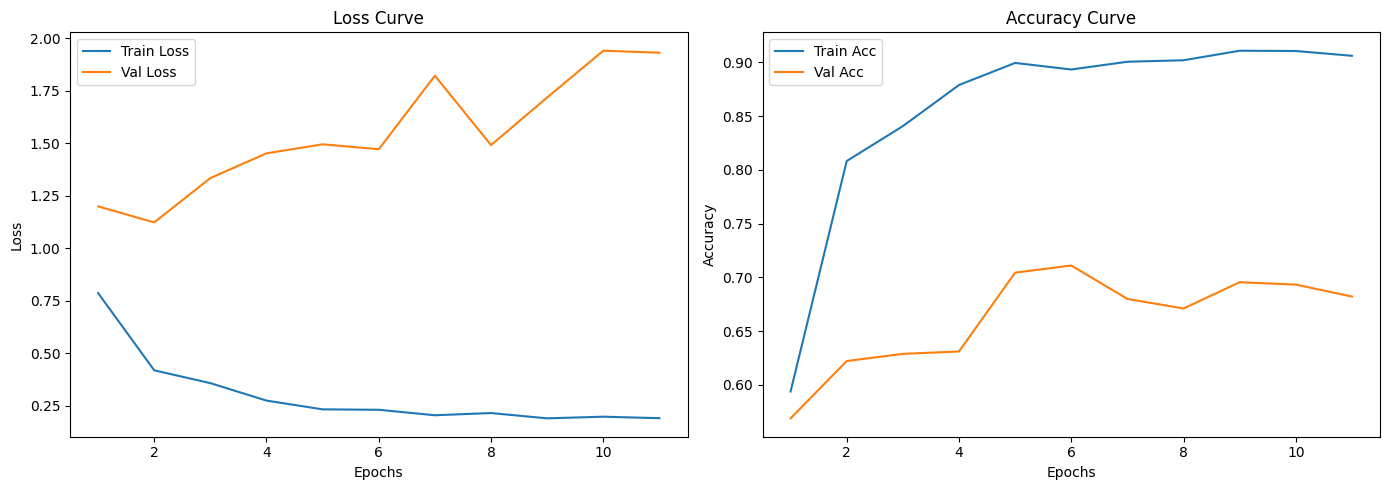

In [35]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# 📉 Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# 📈 Courbe d’accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Acc")
plt.plot(epochs_range, val_accuracies, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


### Évaluation sur le jeu de test

In [36]:
# 📊 Évaluation du modèle sur le jeu de test
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"🎯 Test Accuracy: {test_accuracy:.2f}%")


🎯 Test Accuracy: 73.67%


### Matrice de confusion

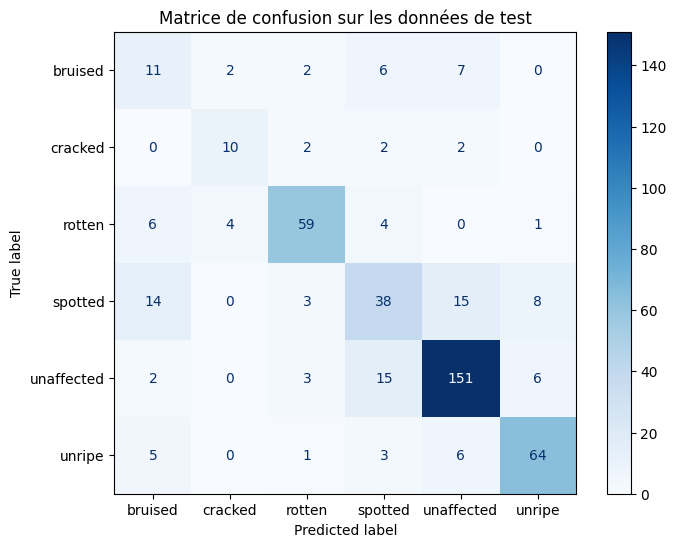

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Matrice de confusion sur les données de test")
plt.show()


### Tester une image précise depuis son chemin

In [38]:
from PIL import Image

def predict_image(img_path, model, transform, class_names):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    
    predicted_label = class_names[predicted.item()]
    
    # 🖼️ Affichage
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"✅ Prédiction : {predicted_label}")
    plt.show()

    return predicted_label


In [40]:
from torchvision import transforms

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Moyenne ImageNet
                         std=[0.229, 0.224, 0.225])    # Écart-type ImageNet
])


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


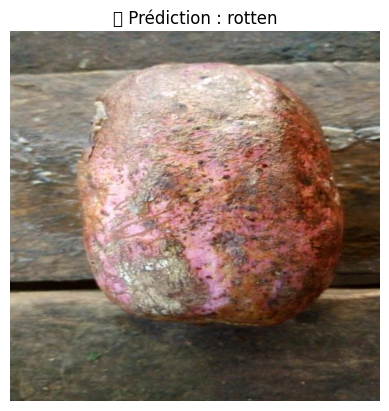

🔍 Vérité terrain : rotten
🤖 Prédiction     : rotten


In [43]:
# Exemple d'utilisation
img_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums/rotten/rotten_plum_12.png"  # Change selon ton image
true_label = "rotten"

predicted = predict_image(img_path, model, val_transform, class_names)
print(f"🔍 Vérité terrain : {true_label}")
print(f"🤖 Prédiction     : {predicted}")


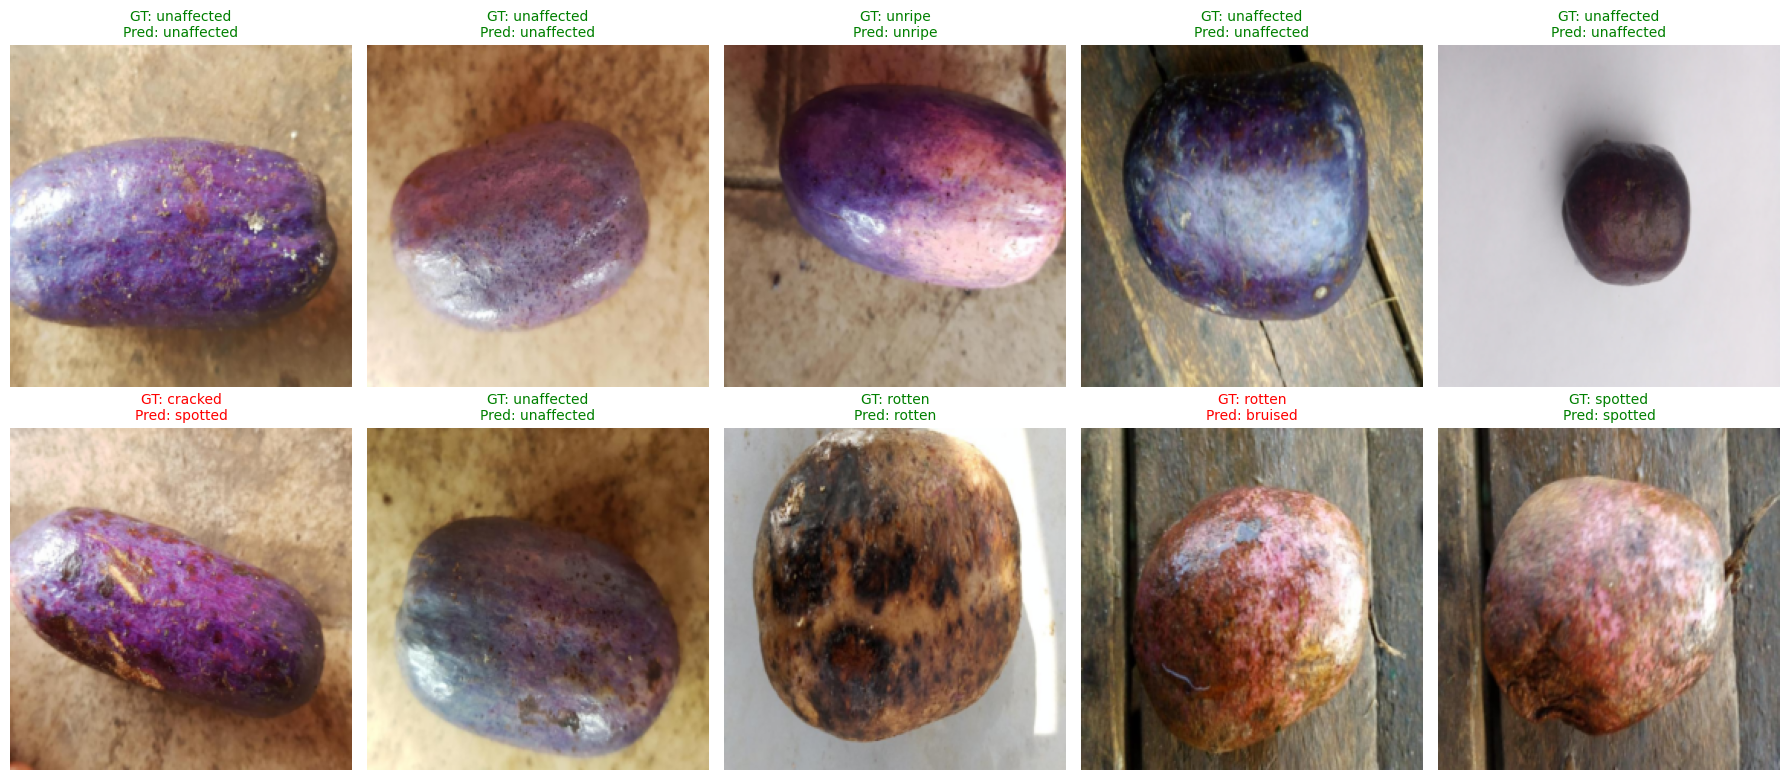

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 🔁 Fonction utilitaire pour afficher une image (dé-normalisée)
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean  # dé-normalisation
    img  = np.clip(img, 0, 1)
    return img

# 🔁 Mettre le modèle en mode évaluation
model.eval()

# 🎯 Sélection aléatoire de 10 échantillons du jeu de test
indices = random.sample(range(len(test_dataset)), 10)
images = [test_dataset[i][0] for i in indices]
labels = [test_dataset[i][1] for i in indices]

# 🧠 Prédictions
with torch.no_grad():
    inputs = torch.stack(images).to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# 🖼️ Affichage
plt.figure(figsize=(18, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = imshow(images[i].cpu())
    ax.imshow(img)
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i]]
    title_color = "green" if true_label == pred_label else "red"
    ax.set_title(f"GT: {true_label}\nPred: {pred_label}", color=title_color, fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()
